In [1]:
# Ensure that you have installed all of the requisite libraries and programs before running this.
# Install matminer by running the command "pip install matminer" in the Bash terminal if you have not already done so.

import requests
requests.packages.urllib3.disable_warnings()
import matplotlib.pyplot as plt
import os, shlex, subprocess
import pandas as pd
from matminer.utils.conversions import str_to_composition
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.svm import LinearSVR
from sklearn.gaussian_process import GaussianProcessRegressor
from scipy.stats import pearsonr, spearmanr
import time
import re
import numpy as np

from sklearn.metrics import *
from sklearn.model_selection import KFold, cross_val_score, GroupKFold, cross_val_predict

original_path = os.getcwd()
ternarpy_path = "plothte_ternary_scalar_zach/"
os.chdir( ternarpy_path )
from ternarpy import *
os.chdir(original_path)




In [2]:
training_data_filename = 'SLAC_Modulus_Only_Cleaned_modified_NoSingles_NoRepeats.txt' # must be tab-delimited text file located in "datasets" folder
featurized_data_name = 'featurized_data'
path_to_magpie = "../slac-metallic-glasses/magpie/dist/Magpie.jar"
n_parallel_processes = 1 # set to -1 to use all cores
training_target_property = 'Youngs_Modulus_GPa' # target property as labeled in the training data file
results_target_property = 'Elastic_Modulus' # target property as it should be labeled in the results
target_property_units = 'GPa'
model_type_name = 'RandomForest'
model = RandomForestRegressor(n_jobs=n_parallel_processes)
model_has_feature_importances = True # make sure that the model selected has the feature_importances_ attribute, otherwise setting to True will result in an error
special_conditions_str = '' # for any special distinction you want to include in file names
eliminate_repeats = True # True to remove duplicates from training set, False to leave them in
duplicate_elimination_mode = False # set to False to remove all entries with compositions that appear multiple times; set to 'first' to keep the first occurence of a repeated composition; set to 'last' to keep only the last occurence

cv_results_name = results_target_property+'_'+model_type_name+'_cv_results'+special_conditions_str
ternary_list = ['Co Ta Zr', 'Fe Nb B', 'Fe Ta Zr', 'Ni Ti Al'] # list of ternary systems you want to predict and plot, with spaces between elements




crossvalidation = KFold(n_splits=10, shuffle=True) # Use 10-fold cross validation (90% training, 10% test)
group_crossvalidation = GroupKFold(n_splits=10)

In [3]:
# make text input file pieces for MAGPIE

load_training_data_str = 'data import datasets/'+training_data_filename
write_feature_data_str = 'data target '+training_target_property+'\nsave data datasets/featurized/'+featurized_data_name+'_stats stats\nsave data datasets/featurized/'+featurized_data_name+'_featurized csv\nsave data datasets/featurized/'+featurized_data_name+'_template template\nsave data datasets/featurized/'+featurized_data_name

os.chdir('magpie-scripts')

with open('load_training_data.txt','w') as f: 
    f.write(load_training_data_str)

with open('write_feature_data.txt','w') as f:
    f.write(write_feature_data_str)

os.chdir(original_path)

In [4]:
# featurize dataset
subprocess.run(["cd",original_path],shell=True)
subprocess.run(["java","-jar","-Xmx5000m",path_to_magpie,"magpie-scripts/MAGPIE_featurizing.txt"])

CompletedProcess(args=['java', '-jar', '-Xmx5000m', '../slac-metallic-glasses/magpie/dist/Magpie.jar', 'magpie-scripts/MAGPIE_featurizing.txt'], returncode=0)

In [5]:
os.getcwd()

'C:\\Users\\rws6\\Machine learning\\MG_elastic_properties_package'

In [6]:
time.sleep(1)
os.chdir('datasets/featurized/')

df = pd.read_csv(featurized_data_name+'_stats.csv',usecols=[0])
df.columns = ['formula']
df["composition"] = df["formula"].transform(str_to_composition)
df = pd.merge(df,pd.read_csv(featurized_data_name+'_featurized.csv'),left_index=True,right_index=True)
if eliminate_repeats:
    df = df.sort_values(by='formula').drop_duplicates('formula',keep=duplicate_elimination_mode)
y = df[training_target_property].values
excluded = ["formula","composition",training_target_property]
X = df.drop(excluded, axis=1)
os.chdir(original_path)
df.head()
#print("There are {} possible descriptors:\n\n{}".format(X.shape[1], X.columns.values))


,formula,composition,NComp,Comp_L2Norm,Comp_L3Norm,Comp_L5Norm,Comp_L7Norm,Comp_L10Norm,mean_Number,maxdiff_Number,...,min_SpaceGroupNumber,most_SpaceGroupNumber,frac_sValence,frac_pValence,frac_dValence,frac_fValence,CanFormIonic,MaxIonicChar,MeanIonicChar,Youngs_Modulus_GPa
582,Al14Fe72B14,"(Al, Fe, B)",3.0,0.746726,0.723512,0.720080,0.720002,0.720000,21.24,21.0,...,166.0,229.0,0.303030,0.042424,0.654545,0.0,0.0,0.045173,0.006406,215.0
309,Al19Fe81,"(Al, Fe)",2.0,0.831986,0.813470,0.810115,0.810005,0.810000,23.53,13.0,...,225.0,229.0,0.283688,0.026950,0.689362,0.0,0.0,0.012027,0.003702,96.0
315,Al2Fe28Ni49B6P14,"(Al, Fe, Ni, B, P)",5.0,0.589746,0.525366,0.497097,0.491772,0.490258,23.92,23.0,...,2.0,225.0,0.245098,0.061275,0.693627,0.0,0.0,0.080661,0.007565,97.0
363,Al2Fe76Si2P16C4,"(Al, Fe, Si, P, C)",5.0,0.778203,0.762402,0.760063,0.760002,0.760000,22.94,20.0,...,2.0,229.0,0.278552,0.086351,0.635097,0.0,0.0,0.198203,0.017098,103.0
428,Al3Co15Ni60B6P16,"(Al, Co, Ni, B, P)",5.0,0.642339,0.607059,0.600280,0.600013,0.600000,23.94,23.0,...,2.0,225.0,0.237530,0.067696,0.694774,0.0,0.0,0.080661,0.007333,123.0


In [7]:
os.chdir('Results/')

results_path = os.getcwd()




model.fit(X, y)



y_predicted = cross_val_predict(model, X, y, cv=crossvalidation)
cv_results = pd.DataFrame({'composition': df['formula'], 'Measured_'+results_target_property: y, 'Predicted_'+results_target_property: y_predicted})


cv_mse_score = mean_squared_error(y, y_predicted)
cv_rmse_score = np.sqrt(cv_mse_score)
cv_r2_score = r2_score(y, y_predicted)
cv_expVar_score = explained_variance_score(y, y_predicted)
cv_mae_score = mean_absolute_error(y, y_predicted)
# cv_msle_score = mean_squared_log_error(y, y_predicted)
cv_medae_score = median_absolute_error(y, y_predicted)

cv_stats_df = pd.DataFrame({'Scores': pd.Series({'R2 score': cv_r2_score,
                                                  'Pearson\'s Correlation': pearsonr(y, y_predicted)[0],
                                                  'Spearman\'s Correlation': spearmanr(y, y_predicted)[0],
                                                  'RMSE': cv_rmse_score,
                                                  'MSE': cv_mse_score,
                                                  'Explained Variance': cv_expVar_score,
                                                  'Mean Absolute Error': cv_mae_score,
                                                  'Median Absolute Error': cv_medae_score,
                                                  'Mean Absolute Percentage Error': np.mean(np.abs((y - y_predicted) / y))*100})})


cv_results_path = results_target_property+'/'+model_type_name+'/cv_results/'
if not os.path.exists(cv_results_path):
    os.makedirs(cv_results_path)
os.chdir(cv_results_path)
cv_results_path = os.getcwd()


with pd.ExcelWriter(cv_results_name+'.xlsx') as writer:
    cv_results.to_excel(writer, sheet_name='cv results', index=False)
    cv_stats_df.to_excel(writer, sheet_name='cv stats')

os.chdir('..')
feature_importances_path = 'feature_importances/'
if not os.path.exists(feature_importances_path):
    os.mkdir(feature_importances_path)
os.chdir(feature_importances_path)
feature_importances_path = os.getcwd()

if model_has_feature_importances:
    feature_importances = pd.DataFrame({'feature': X.columns.values, 'importance': model.feature_importances_}) # importance should be model.feature_importances_ for RandomForest
    feature_importances.to_excel(results_target_property+'_'+model_type_name+special_conditions_str+'_feature_importances.xlsx',index=False)

os.chdir(original_path)
cv_stats_df

,Scores
R2 score,0.879456
Pearson's Correlation,0.937831
Spearman's Correlation,0.917441
RMSE,17.807027
MSE,317.090215
Explained Variance,0.879491
Mean Absolute Error,10.284195
Median Absolute Error,5.160000
Mean Absolute Percentage Error,11.469322


In [8]:
os.chdir(cv_results_path)

subprocess.run(["matlab","-nodisplay","-nosplash","-nodesktop","-r","cd(\'"+cv_results_path+"\'); elementStats(\'"+cv_results_name+".xlsx"+"\',\'"+cv_results_name+"_element_stats.xlsx"+"\',\'descend\',\'merge\',\'stats\',\'logical\'); exit;"])

while not os.path.exists('mat2py_link.txt'):
    time.sleep(1)

os.remove('mat2py_link.txt')
os.chdir(original_path)


In [10]:
os.chdir(cv_results_path)


systems = pd.read_excel(cv_results_name+'_element_stats.xlsx',sheet_name="element systems").systems.values


y_predicted = cross_val_predict(model, X, y, groups=systems, cv=group_crossvalidation)
group_cv_results = pd.DataFrame({'composition': df['formula'], 'Measured_'+results_target_property: y, 'Predicted_'+results_target_property: y_predicted})

group_cv_mse_score = mean_squared_error(y, y_predicted)
group_cv_rmse_score = np.sqrt(group_cv_mse_score)
group_cv_r2_score = r2_score(y, y_predicted)
group_cv_expVar_score = explained_variance_score(y, y_predicted)
group_cv_mae_score = mean_absolute_error(y, y_predicted)
# group_cv_msle_score = mean_squared_log_error(y, y_predicted)
group_cv_medae_score = median_absolute_error(y, y_predicted)

group_cv_stats_df = pd.DataFrame({'Scores': pd.Series({'R2 score': group_cv_r2_score,
                                                      'Pearson\'s Correlation': pearsonr(y, y_predicted)[0],
                                                      'Spearman\'s Correlation': spearmanr(y, y_predicted)[0],
                                                      'RMSE': group_cv_rmse_score,
                                                      'MSE': group_cv_mse_score,
                                                      'Explained Variance': group_cv_expVar_score,
                                                      'Mean Absolute Error': group_cv_mae_score,
                                                      'Median Absolute Error': group_cv_medae_score,
                                                      'Mean Absolute Percentage Error': np.mean(np.abs((y - y_predicted) / y))*100})})



group_cv_results_path = results_target_property+'/'+model_type_name+'/group_cv_results/'
if not os.path.exists(group_cv_results_path):
    os.makedirs(group_cv_results_path)
os.chdir(group_cv_results_path)

with pd.ExcelWriter('group_'+cv_results_name+'.xlsx') as writer:
    group_cv_results.to_excel(writer, sheet_name='group cv results', index=False)
    group_cv_stats_df.to_excel(writer, sheet_name='group cv stats')



# print('Group Cross-validation performance statistics:')
# print('Folds: %i, R2: %.3f' % (10, group_cv_r2_score))
# print('Folds: %i, RMSE: %.3f' % (10, group_cv_rmse_score))
# print('Folds: %i, MSE: %.3f' % (10, group_cv_mse_score))
# print('Folds: %i, Explained Variance: %.3f' % (10, group_cv_expVar_score))
# print('Folds: %i, MAE: %.3f' % (10, group_cv_mae_score))
# # print('Folds: %i, mean MSLE: %.3f' % (10, group_cv_msle_score))
# print('Folds: %i, Median Absolute Error: %.3f' % (10, group_cv_medae_score))

os.chdir(original_path)

group_cv_stats_df


,Scores
R2 score,0.831559
Pearson's Correlation,0.912264
Spearman's Correlation,0.888178
RMSE,21.049584
MSE,443.084996
Explained Variance,0.832185
Mean Absolute Error,12.580784
Median Absolute Error,7.100000
Mean Absolute Percentage Error,14.156106


In [12]:
# Iterative Holdout Validation; only does something if all repeats were removed from training set

if eliminate_repeats:
    os.chdir(cv_results_path)

    regex = re.compile(".*(logic table k).*")

    with pd.ExcelFile(cv_results_name+'_element_stats.xlsx') as xlsx:
        target_sheets = [m.group(0) for l in xlsx.sheet_names for m in [regex.search(l)] if m]
        logicDF_dict = pd.read_excel(xlsx, target_sheets)


    leave_out_combo_df_template = pd.DataFrame({'Measured_'+results_target_property: y})
    leave_out_combo_df_template.index=df.formula.values

    holdout_combo = model

    leave_out_combo_df_dict = {}
    val_scores_df_dict = {}
    full_val_scores_df_dict = {}
    training_scores_df_dict = {}

    regex = re.compile(".*(\d+).*")

    for key, logicDF in logicDF_dict.items():
        k_str = regex.search(key).group(1)
        leave_out_combo_df = pd.DataFrame({'Measured_'+results_target_property: y},index=df.formula.values)
        val_scores_df = pd.DataFrame()
        full_val_scores_df = pd.DataFrame()
        training_scores_df = pd.DataFrame()
        logicDF.index = logicDF['Row'].values
        del logicDF['Row']
        for col in logicDF:
            logicVec=logicDF[col].values>0
            holdout_y = y[logicVec]
            holdout_X = X[logicVec]
            train_X = X[logicVec<1]
            train_y = y[logicVec<1]
            holdout_combo.fit(train_X, train_y)
            prediction = holdout_combo.predict(holdout_X)
            full_prediction = holdout_combo.predict(X)
            train_prediction = holdout_combo.predict(train_X)
            predictionSeries = pd.Series(prediction, index=df.formula[logicVec])
            leave_out_combo_df[col]=predictionSeries
            if sum(logicVec)>6:
                pearsonscore1=pearsonr(holdout_y, prediction)[0]
                spearmanscore1=spearmanr(holdout_y, prediction)[0]
                pearsonscore2=pearsonr(y, full_prediction)[0]
                spearmanscore2=spearmanr(y, full_prediction)[0]
                pearsonscore3=pearsonr(train_y, train_prediction)[0]
                spearmanscore3=spearmanr(train_y, train_prediction)[0]
            else:
                pearsonscore1=float('nan')
                spearmanscore1=float('nan')
                pearsonscore2=pearsonr(y, full_prediction)[0]
                spearmanscore2=spearmanr(y, full_prediction)[0]
                pearsonscore3=pearsonr(train_y, train_prediction)[0]
                spearmanscore3=spearmanr(train_y, train_prediction)[0]
            val_scores_df[col]=pd.Series({'Holdout size': sum(logicVec),
                                          'R2 score': r2_score(holdout_y,prediction),
                                          'Pearson\'s Correlation': pearsonscore1,
                                          'Spearman\'s Correlation': spearmanscore1,
                                          'Median Absolute Error': median_absolute_error(holdout_y,prediction),
                                          #'Mean Squared Log Error': mean_squared_log_error(holdout_y,prediction),
                                         'Mean Squared Error': mean_squared_error(holdout_y,prediction),
                                         'Mean Absolute Error': mean_absolute_error(holdout_y,prediction),
                                         'Explained Variance score': explained_variance_score(holdout_y,prediction),
                                         'Mean Absolute Percentage Error': np.mean(np.abs((holdout_y - prediction) / holdout_y))*100})
            full_val_scores_df[col]=pd.Series({'Holdout size': sum(logicVec),
                                               'R2 score': r2_score(y,full_prediction),
                                              'Pearson\'s Correlation': pearsonscore2,
                                              'Spearman\'s Correlation': spearmanscore2,
                                              'Median Absolute Error': median_absolute_error(y,full_prediction),
                                              #'Mean Squared Log Error': mean_squared_log_error(y,full_prediction),
                                                'Mean Squared Error': mean_squared_error(y,full_prediction),
                                                'Mean Absolute Error': mean_absolute_error(y,full_prediction),
                                                'Explained Variance score': explained_variance_score(y,full_prediction),
                                              'Mean Absolute Percentage Error': np.mean(np.abs((y - full_prediction) / y))*100})
            training_scores_df[col]=pd.Series({'Holdout size': sum(logicVec),
                                               'R2 score': r2_score(train_y, train_prediction),
                                              'Pearson\'s Correlation': pearsonscore3,
                                              'Spearman\'s Correlation': spearmanscore3,
                                              'Median Absolute Error': median_absolute_error(train_y,train_prediction),
                                              #'Mean Squared Log Error': mean_squared_log_error(train_y,train_prediction),
                                                'Mean Squared Error': mean_squared_error(train_y,train_prediction),
                                                'Mean Absolute Error': mean_absolute_error(train_y,train_prediction),
                                                'Explained Variance score': explained_variance_score(train_y,train_prediction),
                                              'Mean Absolute Percentage Error': np.mean(np.abs((train_y - train_prediction) / train_y))*100})
        leave_out_combo_df_dict[k_str] = leave_out_combo_df
        val_scores_df_dict[k_str] = val_scores_df
        full_val_scores_df_dict[k_str] = full_val_scores_df
        training_scores_df_dict[k_str] = training_scores_df
    
    os.chdir(results_path)
    iterative_holdout_path = results_target_property+'/'+model_type_name+'/iterative_holdout/'
    if not os.path.exists(iterative_holdout_path):
        os.makedirs(iterative_holdout_path)
    os.chdir(iterative_holdout_path)
    with pd.ExcelWriter(cv_results_name+'_iterative_holdout.xlsx') as writer:
        for key in leave_out_combo_df_dict:
            leave_out_combo_df_dict[key].to_excel(writer, sheet_name='k='+key+' holdout predictions')
            val_scores_df_dict[key].to_excel(writer, sheet_name='k='+key+' holdout val scores')
            full_val_scores_df_dict[key].to_excel(writer, sheet_name='k='+key+' full set val scores')
            training_scores_df_dict[key].to_excel(writer, sheet_name='k='+key+' training scores')


    os.chdir(original_path)

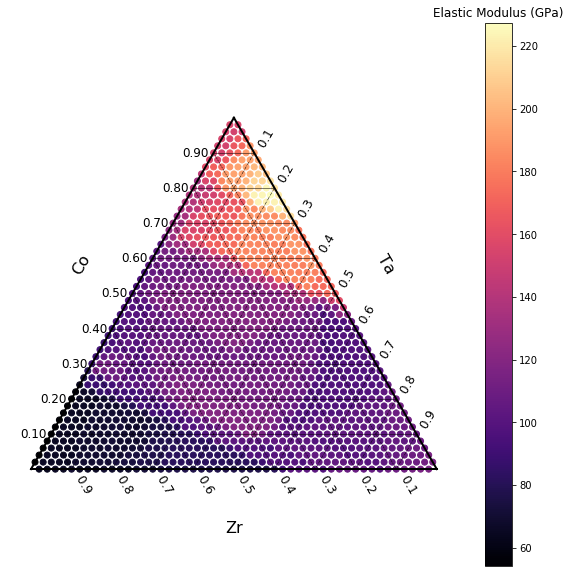

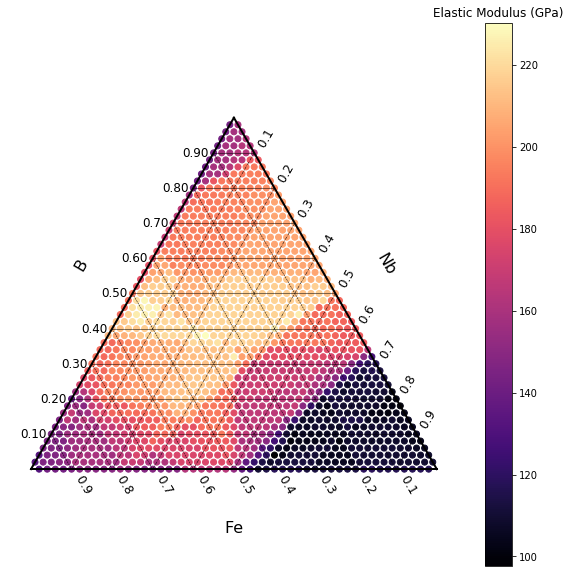

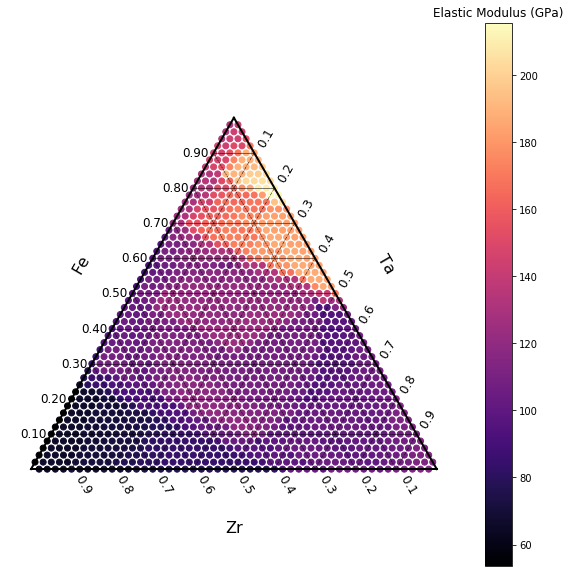

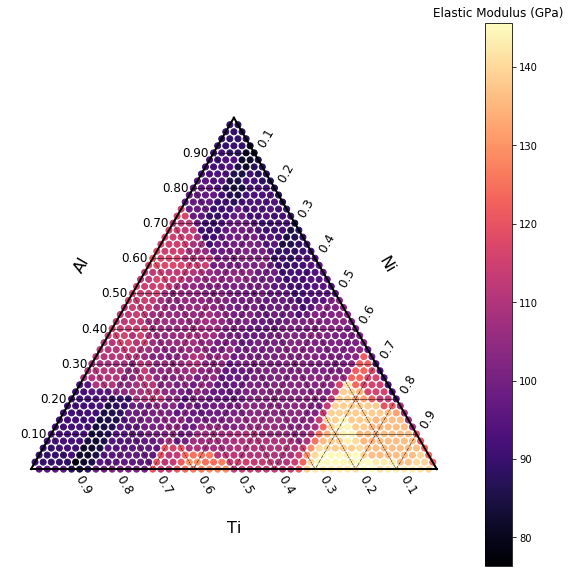

In [13]:
# Predict and plot selected ternaries
for c in ternary_list:
    key=c.replace(' ','').replace(',','').replace('_','')
    ternary_generation_str = 'data generate PhaseDiagramCompositionEntryGenerator 2 3 -alloy 2 '+c
    write_ternary_feature_data_str = 'save data datasets/featurized/ternary/'+key+'_'+featurized_data_name+'_stats stats\nsave data datasets/featurized/ternary/'+key+'_'+featurized_data_name+'_featurized csv\nsave data datasets/featurized/ternary/'+key+'_'+featurized_data_name+'_template template\nsave data datasets/featurized/ternary/'+key+'_'+featurized_data_name
    os.chdir('magpie-scripts')
    with open('ternary_generation_line.txt','w') as f: 
        f.write(ternary_generation_str)
    with open('write_ternary_feature_data.txt','w') as f:
        f.write(write_ternary_feature_data_str)
    os.chdir(original_path)
    subprocess.run(["cd",original_path],shell=True)
    subprocess.run(["java","-jar",path_to_magpie,"magpie-scripts/ternary_composition_generator.txt"])
    time.sleep(2)
    os.chdir('datasets/featurized/ternary/')
    df_ternary = pd.read_csv(key+'_'+featurized_data_name+'_stats.csv',usecols=[0])
    df_ternary.columns = ['composition']
    df_ternary = pd.merge(df_ternary,pd.read_csv(key+'_'+featurized_data_name+'_featurized.csv'),left_index=True,right_index=True)
    excluded = ["composition","Class"]
    os.chdir(original_path)
    ternary_results_path = 'Results/'+results_target_property+'/'+model_type_name+'/ternary_predictions/'+key+'_predictions/'
    if not os.path.exists(ternary_results_path):
        os.makedirs(ternary_results_path)
    os.chdir(ternary_results_path)
    ternary_results_path = os.getcwd()
    X_ternary = df_ternary.drop(excluded, axis=1)
    y_ternary = model.predict(X_ternary)
    dfResultsTernary = pd.DataFrame({'composition': df_ternary['composition'].values,
                                   results_target_property: y_ternary})
    dfResultsTernary.to_excel(key+'_'+results_target_property+'_'+model_type_name+'_predictions.xlsx', sheet_name=key+' predictions',index=False)
    subprocess.run(["matlab","-nodisplay","-nosplash","-nodesktop","-r","cd(\'"+ternary_results_path+"\'); reformat4ternary(\'"+key+'_'+results_target_property+'_'+model_type_name+'_predictions.xlsx'+"\',\'"+results_target_property+"\'); exit;"])
    while not os.path.exists('mat2py_link.txt'):
        time.sleep(2)
    os.remove('mat2py_link.txt')
    ternary_df = pd.read_excel('ref_'+key+'_'+results_target_property+'_'+model_type_name+'_predictions.xlsx', header = 0)
    columns = list(ternary_df)
    basis = make_basis()
    tern_X = ternary_df.iloc[:,0:3].values
    tern_Xt = transform(tern_X,basis)
    fig, ax = pylab.subplots(figsize=(10,10))
    setup_plot(ax, side_labels= columns[0:3], grid_values=np.arange(0.1,1,0.1))
    points = ax.scatter(tern_Xt[:,0],tern_Xt[:,1],c=ternary_df[results_target_property], cmap='magma', vmin=ternary_df[results_target_property].min(), vmax=ternary_df[results_target_property].max());
    plt.colorbar(points).ax.set_title(results_target_property.replace('_',' ')+' ('+target_property_units+')')
    os.chdir(original_path)
    tern_plot_path = 'ternary_plots/'+results_target_property+'/'+model_type_name+'/'
    if not os.path.exists(tern_plot_path):
        os.makedirs(tern_plot_path)
    os.chdir(tern_plot_path)
    plt.savefig(key+'_'+results_target_property+'_'+model_type_name+'_predictions.pdf', bbox_inches='tight')
    os.chdir(original_path)

    
    


In [14]:
os.chdir(original_path)